# Segmentation map으로 도로 이미지 만들기

Pix2Pix를 이용하여 도로이미지 생성

In [22]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers, Input, Model, losses, optimizers
from tensorflow import image, data

## 데이터 불러오기

In [12]:
data_path = os.getcwd() + '/train/'

print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [33]:
# -1 ~ 1로 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 0 ~ 255로 다시 돌려두기
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 이미지 불러오기
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    # 받아오는 이미지는 256*256이미지가 붙어있는 256*512이다.이를 반으로 나누어준다.
    w = tf.shape(img)[1] // 2
    real_img = img[:, :w, :] 
    real_img = tf.cast(real_img, tf.float32) # tf.cast 값을 tf.float32형으로 변환
    seg_img = img[:, w:, :] 
    seg_img = tf.cast(seg_img, tf.float32)
    return normalize(real_img), normalize(seg_img)

f = data_path + os.listdir(data_path)[5]
real_img, seg_img = load_img(f)

print('size of image : ', real_img.shape)

size of image :  (256, 256, 3)


## 데이터 증가(Data augmentation)

In [14]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(real_img, seg_img):
    stacked = tf.concat([real_img, seg_img], axis=-1) 
    
    # [위,아래][왼,우][앞,뒤] 행렬의 rank를 인수만큼 증가시킨다.
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    
    # pad를 추가한 이미지를 다시 원래의 사이즈로 자르기.
    out = image.random_crop(padded, size=[256, 256, 6]) 
    
    # 랜덤적으로 반전 이미지 생성
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    # 50%의 확률로 이미지가 (90,180,270)도 회전한다.
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    # 결과를 다시 나누어준다.
    return out[...,:3], out[...,3:]   

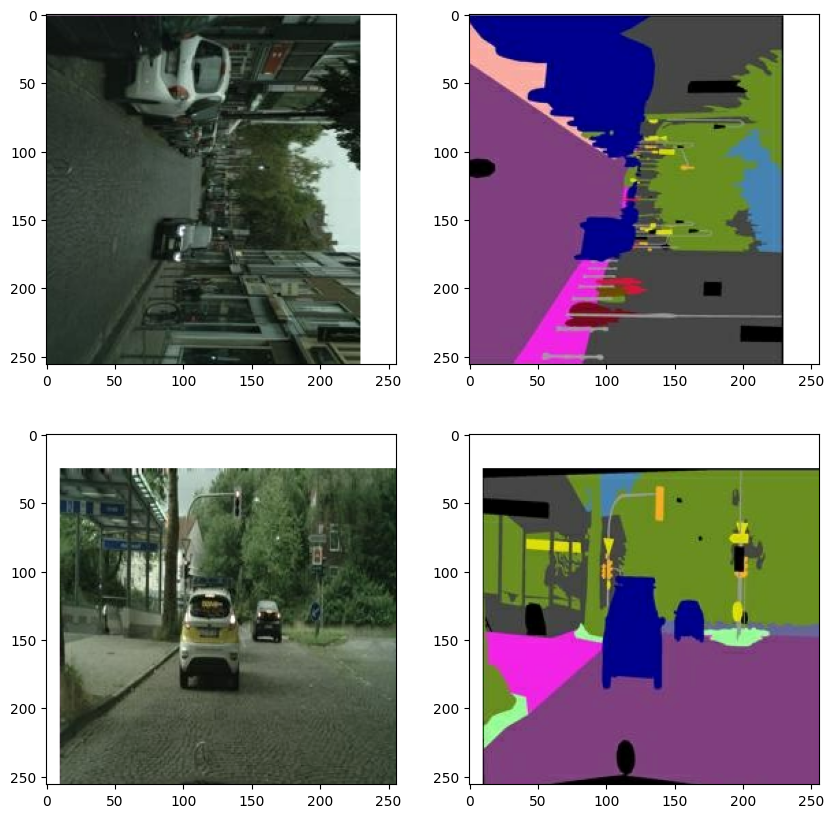

In [34]:
def get_train(img_path):
    real_img, seg_img = load_img(img_path)
    real_img, seg_img = apply_augmentation(real_img, seg_img)
    return real_img, seg_img

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
real_img, seg_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,10))
plt.subplot(2,2,1); plt.imshow(real_img[0].astype(np.uint8))
plt.subplot(2,2,2); plt.imshow(seg_img[0].astype(np.uint8))
plt.subplot(2,2,3); plt.imshow(real_img[1].astype(np.uint8))
plt.subplot(2,2,4); plt.imshow(seg_img[1].astype(np.uint8))

## Generator 구현하기

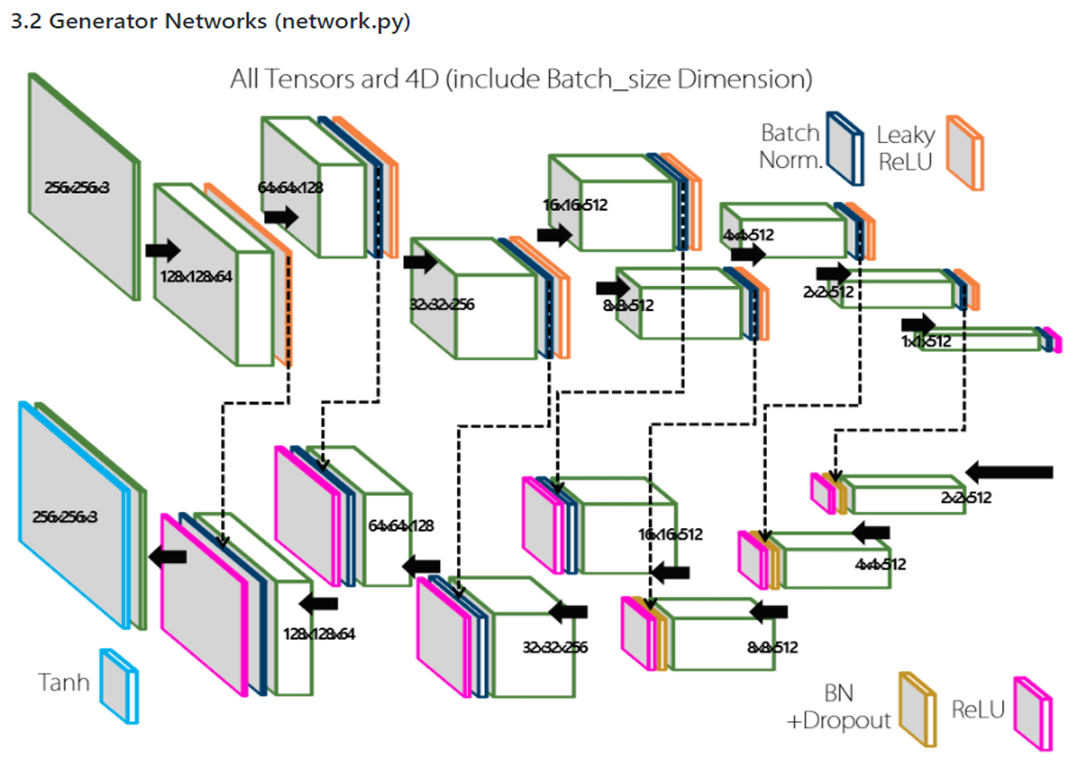

Ck : Convolution - BatchNorm - ReLU층에 k개의 필터가 있다.   
CDk : Convolution - BatchNorm - Dropout - ReLU 층에 k개의 필터, Dropout은 50%   
모든  Conv 층에는 4*4 filter에 stride 2 적용   

마지막 Decoder에서 output channels을 3개의 chennels로 설정, Tanh function.   
BatchNorm은 Encoder의 첫번째 C64에서는 미적용.   
Encoder의 ReLU는 slope가 0.2인 leaky ReLU, Decoder는 slope가 0ㅇ인 ReLU적용   

* **Encoder**
    + C64 - C128 - C256 - C512 - C512 - C512 - C512 - C512   
* **Decoder**
    + CD512 - CD512 - CD512 - C512 - C256 - C128 - C64   
* **U-Net Decoder**
    + CD512 - CD1024 - CD1024 - C1024 - C512 - C256 - C128   
    + 즉 CD512 - CD(512+512) - CD(512+512) - C(512+512) - C(256+256) - C(128+128) - C(64+64) 

In [16]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for enc_block in self.encode_blocks:
            x = enc_block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for dec_block, feat in zip(self.decode_blocks, features[::-1]):
            x = dec_block(x)
            x = layers.Concatenate()([x, feat])
            
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [18]:
UNetGenerator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                            

## Discriminator

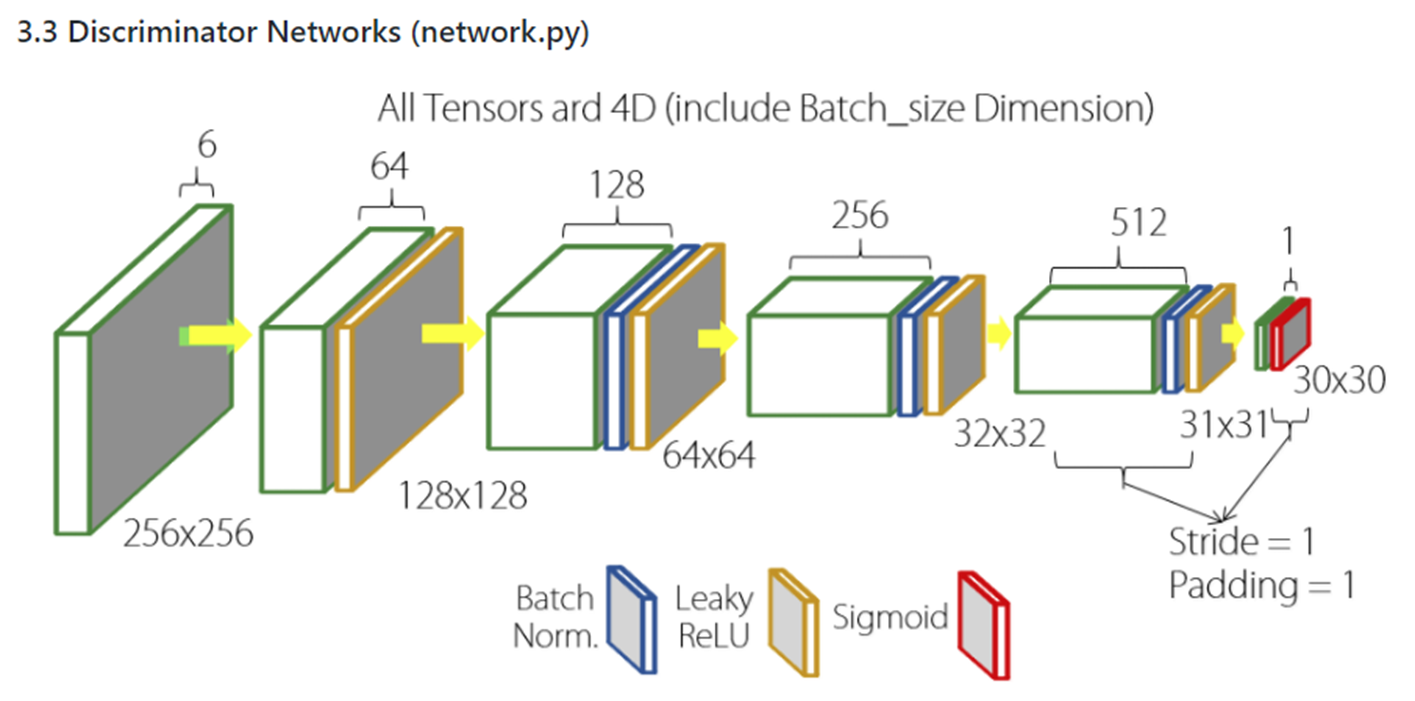    

* C64 - C128 - C256 - C512

* Convolution 층은 4*4필터에 stride 2.
* 모든 ReLU는 slope가 0.2인 leaky ReLU적용 

In [19]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

* 첫번째 층과 마지막 층에는 BatchNorm을 적용하지 않음.
* 마지막 두개의 층에 pading과 stride를 1로 적용

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]

        self.blocks.append(DiscBlock(64, use_bn=False))
        self.blocks.append(DiscBlock(128))
        self.blocks.append(DiscBlock(256))
        self.blocks.append(DiscBlock(512, stride=1, custom_pad=True))
        self.blocks.append(DiscBlock(1, stride=1, custom_pad=True, use_bn=False, act=False))

    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)

        return tf.keras.activations.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_14 (Concatenate)   (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

## Loss, Optimizer 정의하기

In [32]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [36]:
generator = UNetGenerator()
discriminator = Discriminator()

@tf.function()
def train_step(seg_img, real_img):

    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_img = generator(seg_img)

        real_disc = discriminator(real_img, seg_img)
        fake_disc = discriminator(fake_img, seg_img)

        gene_loss, l1_loss = get_gene_loss(fake_img, real_img, fake_disc)
        disc_loss = get_disc_loss(fake_disc, real_disc)

    grad_gen = gene_tape.gradient(gene_loss, generator.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(grad_gen, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [39]:
EPOCHS = 20

for epoch in range(1, EPOCHS+1):
    for i, (real_img, seg_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg_img, real_img)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.7732                     
L1_loss:0.2895                     
Discriminator_loss:1.2473

EPOCH[1] - STEP[20]                     
Generator_loss:1.0607                     
L1_loss:0.3240                     
Discriminator_loss:1.1973

EPOCH[1] - STEP[30]                     
Generator_loss:0.9586                     
L1_loss:0.3220                     
Discriminator_loss:1.1222

EPOCH[1] - STEP[40]                     
Generator_loss:0.9365                     
L1_loss:0.2657                     
Discriminator_loss:1.2174

EPOCH[1] - STEP[50]                     
Generator_loss:0.9148                     
L1_loss:0.2880                     
Discriminator_loss:1.1624

EPOCH[1] - STEP[60]                     
Generator_loss:0.9909                     
L1_loss:0.3411                     
Discriminator_loss:1.4220

EPOCH[1] - STEP[70]                     
Generator_loss:1.3384                     
L1_loss:0.2974                    

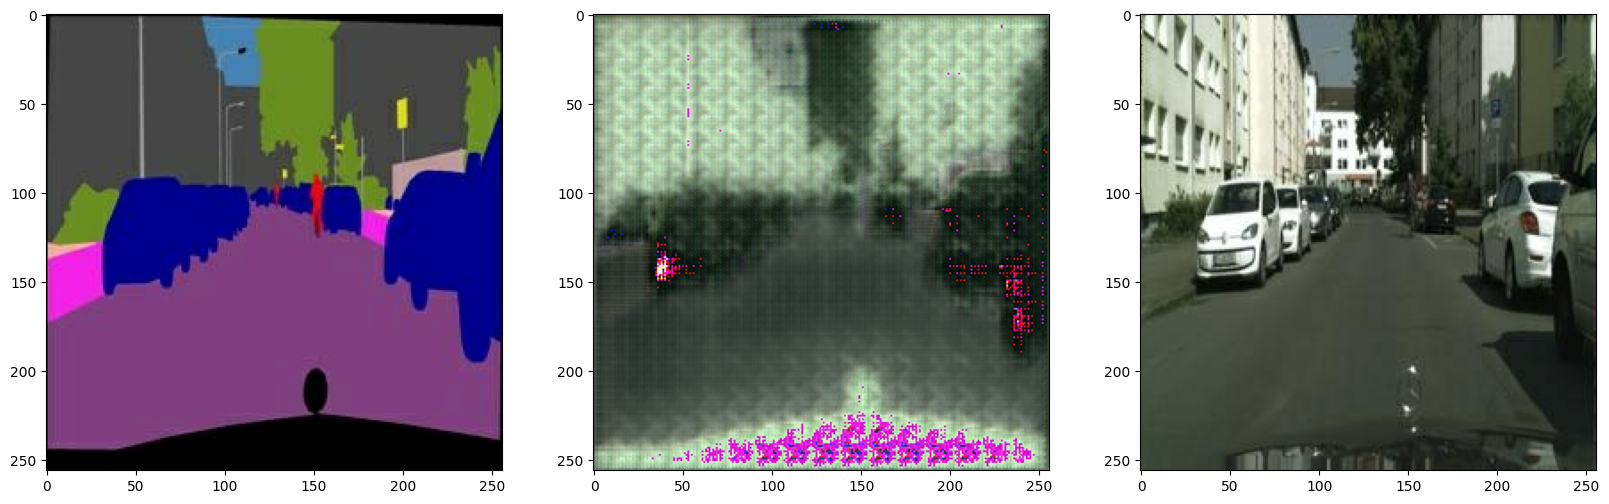

In [41]:
test_ind = 1

test_data_path = os.getcwd() + '/val/'

f = test_data_path + os.listdir(test_data_path)[test_ind]
real_img, seg_img = load_img(f)

pred = generator(tf.expand_dims(seg_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(real_img))

총 30 Epoch를 실행하여 다음과 같은결과를 얻었습니다.